Centro de Estudos e Sistemas Avançados do Recife

Pós-graduação em Engenharia e Análise de Dados

Disciplina de RNA e Deep Learning

Professor: Silvan Ferreira da Silva Junior 
 
Grupo:
* Anísio Pereira Batista Filho (apbf@cesar.school)
* Carlos Cezar Lopes de Mendonça (cclm@cesar.school)
* Rodolpho Victor França Valsconcelos (rvfv@cesar.school)

In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')
        
        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [7]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [8]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [10]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Epoch 1, Train Loss: 2.297, Train Accuracy: 15.00%
Epoch 1, Val Loss: 2.222, Val Accuracy: 27.20%


100%|██████████| 16/16 [00:02<00:00,  6.55it/s]


Epoch 2, Train Loss: 2.107, Train Accuracy: 29.80%
Epoch 2, Val Loss: 1.867, Val Accuracy: 46.00%


100%|██████████| 16/16 [00:02<00:00,  5.81it/s]


Epoch 3, Train Loss: 1.574, Train Accuracy: 50.50%
Epoch 3, Val Loss: 1.017, Val Accuracy: 69.80%


100%|██████████| 16/16 [00:02<00:00,  7.09it/s]


Epoch 4, Train Loss: 0.944, Train Accuracy: 70.30%
Epoch 4, Val Loss: 0.584, Val Accuracy: 81.00%


100%|██████████| 16/16 [00:02<00:00,  6.30it/s]


Epoch 5, Train Loss: 0.631, Train Accuracy: 78.70%
Epoch 5, Val Loss: 0.504, Val Accuracy: 85.00%
Treinamento concluído


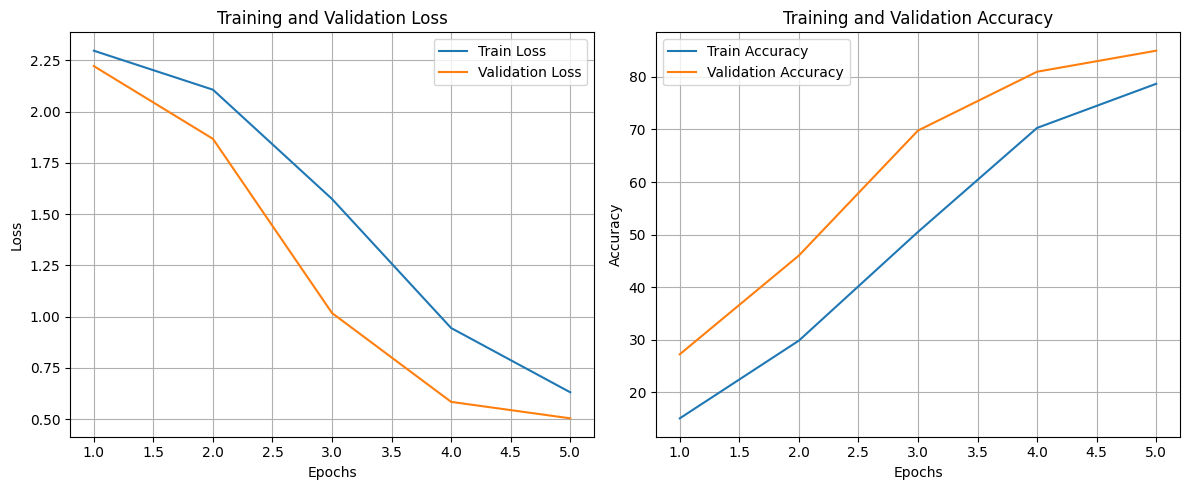

In [11]:
epochs = range(1, len(history['train_losses']) + 1)
    
# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
test_model(model, testloader)

Acurácia da rede na base de teste: 82.80%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [13]:
class CNN_2(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_1=6, num_filters_2=12, num_hidden=64):
        super(CNN_2, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, num_hidden)
        self.fc2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

parameters_combinations = [(6,12), (6,16), (8,12), (8,16)]

for num_filters_1, num_filters_2 in parameters_combinations:
  print(f'Treinamento com {num_filters_1} filtros na primeira camada e {num_filters_2} filtros na segunda camada')
  model = CNN_2(
      initialize_weights = True,
      dropout=0.1,
      num_filters_1 = num_filters_1,
      num_filters_2 = num_filters_2
  )

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

  history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
  )

  test_model(model, testloader)

Treinamento com 6 filtros na primeira camada e 12 filtros na segunda camada


100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


Epoch 1, Train Loss: 2.286, Train Accuracy: 14.30%
Epoch 1, Val Loss: 2.194, Val Accuracy: 26.80%


100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


Epoch 2, Train Loss: 1.989, Train Accuracy: 36.70%
Epoch 2, Val Loss: 1.600, Val Accuracy: 51.40%


100%|██████████| 16/16 [00:03<00:00,  4.83it/s]


Epoch 3, Train Loss: 1.211, Train Accuracy: 62.70%
Epoch 3, Val Loss: 0.783, Val Accuracy: 74.00%


100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Epoch 4, Train Loss: 0.684, Train Accuracy: 77.40%
Epoch 4, Val Loss: 0.588, Val Accuracy: 81.60%


100%|██████████| 16/16 [00:03<00:00,  5.01it/s]


Epoch 5, Train Loss: 0.448, Train Accuracy: 84.30%
Epoch 5, Val Loss: 0.450, Val Accuracy: 85.40%
Treinamento concluído
Acurácia da rede na base de teste: 88.20%
Treinamento com 6 filtros na primeira camada e 16 filtros na segunda camada


100%|██████████| 16/16 [00:03<00:00,  4.07it/s]


Epoch 1, Train Loss: 2.228, Train Accuracy: 19.40%
Epoch 1, Val Loss: 1.995, Val Accuracy: 46.20%


100%|██████████| 16/16 [00:02<00:00,  5.63it/s]


Epoch 2, Train Loss: 1.590, Train Accuracy: 49.80%
Epoch 2, Val Loss: 1.023, Val Accuracy: 69.20%


100%|██████████| 16/16 [00:02<00:00,  5.80it/s]


Epoch 3, Train Loss: 0.894, Train Accuracy: 70.00%
Epoch 3, Val Loss: 0.615, Val Accuracy: 80.80%


100%|██████████| 16/16 [00:04<00:00,  3.97it/s]


Epoch 4, Train Loss: 0.559, Train Accuracy: 81.90%
Epoch 4, Val Loss: 0.466, Val Accuracy: 86.40%


100%|██████████| 16/16 [00:04<00:00,  3.75it/s]


Epoch 5, Train Loss: 0.426, Train Accuracy: 86.00%
Epoch 5, Val Loss: 0.375, Val Accuracy: 88.20%
Treinamento concluído
Acurácia da rede na base de teste: 91.80%
Treinamento com 8 filtros na primeira camada e 12 filtros na segunda camada


100%|██████████| 16/16 [00:03<00:00,  5.05it/s]


Epoch 1, Train Loss: 2.268, Train Accuracy: 16.50%
Epoch 1, Val Loss: 2.187, Val Accuracy: 27.80%


100%|██████████| 16/16 [00:04<00:00,  3.47it/s]


Epoch 2, Train Loss: 1.979, Train Accuracy: 35.00%
Epoch 2, Val Loss: 1.655, Val Accuracy: 48.20%


100%|██████████| 16/16 [00:03<00:00,  4.68it/s]


Epoch 3, Train Loss: 1.293, Train Accuracy: 58.50%
Epoch 3, Val Loss: 0.841, Val Accuracy: 74.20%


100%|██████████| 16/16 [00:03<00:00,  4.55it/s]


Epoch 4, Train Loss: 0.676, Train Accuracy: 77.80%
Epoch 4, Val Loss: 0.515, Val Accuracy: 84.00%


100%|██████████| 16/16 [00:02<00:00,  5.47it/s]


Epoch 5, Train Loss: 0.479, Train Accuracy: 84.30%
Epoch 5, Val Loss: 0.392, Val Accuracy: 89.00%
Treinamento concluído
Acurácia da rede na base de teste: 87.40%
Treinamento com 8 filtros na primeira camada e 16 filtros na segunda camada


100%|██████████| 16/16 [00:02<00:00,  7.53it/s]


Epoch 1, Train Loss: 2.197, Train Accuracy: 22.40%
Epoch 1, Val Loss: 2.030, Val Accuracy: 33.00%


100%|██████████| 16/16 [00:01<00:00,  8.48it/s]


Epoch 2, Train Loss: 1.693, Train Accuracy: 48.50%
Epoch 2, Val Loss: 1.214, Val Accuracy: 63.60%


100%|██████████| 16/16 [00:02<00:00,  6.04it/s]


Epoch 3, Train Loss: 0.926, Train Accuracy: 69.50%
Epoch 3, Val Loss: 0.771, Val Accuracy: 76.60%


100%|██████████| 16/16 [00:03<00:00,  4.27it/s]


Epoch 4, Train Loss: 0.573, Train Accuracy: 81.60%
Epoch 4, Val Loss: 0.453, Val Accuracy: 86.80%


100%|██████████| 16/16 [00:03<00:00,  4.37it/s]


Epoch 5, Train Loss: 0.350, Train Accuracy: 88.50%
Epoch 5, Val Loss: 0.349, Val Accuracy: 88.40%
Treinamento concluído
Acurácia da rede na base de teste: 93.00%


### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [14]:
for i in range(5):
  num_hidden = np.random.randint(10, 100)
  model = CNN_2(num_hidden=num_hidden)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
  )

  print(f'Número de neurônios na camada fully connected: {num_hidden}')
  test_model(model, testloader)
  print()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:02<00:00,  6.07it/s]


Epoch 1, Train Loss: 2.288, Train Accuracy: 12.20%
Epoch 1, Val Loss: 2.194, Val Accuracy: 24.20%


100%|██████████| 16/16 [00:03<00:00,  5.25it/s]


Epoch 2, Train Loss: 2.023, Train Accuracy: 33.10%
Epoch 2, Val Loss: 1.706, Val Accuracy: 52.80%


100%|██████████| 16/16 [00:02<00:00,  6.39it/s]


Epoch 3, Train Loss: 1.306, Train Accuracy: 59.20%
Epoch 3, Val Loss: 0.811, Val Accuracy: 75.20%


100%|██████████| 16/16 [00:03<00:00,  5.04it/s]


Epoch 4, Train Loss: 0.784, Train Accuracy: 73.20%
Epoch 4, Val Loss: 0.485, Val Accuracy: 87.20%


100%|██████████| 16/16 [00:02<00:00,  6.60it/s]


Epoch 5, Train Loss: 0.553, Train Accuracy: 81.40%
Epoch 5, Val Loss: 0.422, Val Accuracy: 87.00%
Treinamento concluído
Número de neurônios na camada fully connected: 55
Acurácia da rede na base de teste: 87.80%



100%|██████████| 16/16 [00:02<00:00,  5.72it/s]


Epoch 1, Train Loss: 2.289, Train Accuracy: 17.10%
Epoch 1, Val Loss: 2.187, Val Accuracy: 34.00%


100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


Epoch 2, Train Loss: 1.991, Train Accuracy: 36.10%
Epoch 2, Val Loss: 1.664, Val Accuracy: 48.00%


100%|██████████| 16/16 [00:03<00:00,  4.14it/s]


Epoch 3, Train Loss: 1.313, Train Accuracy: 54.10%
Epoch 3, Val Loss: 0.922, Val Accuracy: 70.00%


100%|██████████| 16/16 [00:03<00:00,  4.96it/s]


Epoch 4, Train Loss: 0.826, Train Accuracy: 72.20%
Epoch 4, Val Loss: 0.633, Val Accuracy: 79.00%


100%|██████████| 16/16 [00:02<00:00,  6.19it/s]


Epoch 5, Train Loss: 0.590, Train Accuracy: 80.30%
Epoch 5, Val Loss: 0.525, Val Accuracy: 81.80%
Treinamento concluído
Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 85.80%



100%|██████████| 16/16 [00:02<00:00,  5.79it/s]


Epoch 1, Train Loss: 2.280, Train Accuracy: 18.70%
Epoch 1, Val Loss: 2.177, Val Accuracy: 29.00%


100%|██████████| 16/16 [00:02<00:00,  6.32it/s]


Epoch 2, Train Loss: 1.997, Train Accuracy: 34.10%
Epoch 2, Val Loss: 1.588, Val Accuracy: 54.20%


100%|██████████| 16/16 [00:02<00:00,  6.38it/s]


Epoch 3, Train Loss: 1.257, Train Accuracy: 59.40%
Epoch 3, Val Loss: 0.741, Val Accuracy: 76.40%


100%|██████████| 16/16 [00:02<00:00,  6.47it/s]


Epoch 4, Train Loss: 0.743, Train Accuracy: 75.90%
Epoch 4, Val Loss: 0.503, Val Accuracy: 84.40%


100%|██████████| 16/16 [00:02<00:00,  6.65it/s]


Epoch 5, Train Loss: 0.474, Train Accuracy: 84.80%
Epoch 5, Val Loss: 0.406, Val Accuracy: 87.60%
Treinamento concluído
Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 89.20%



100%|██████████| 16/16 [00:02<00:00,  7.55it/s]


Epoch 1, Train Loss: 2.269, Train Accuracy: 11.90%
Epoch 1, Val Loss: 2.190, Val Accuracy: 23.20%


100%|██████████| 16/16 [00:02<00:00,  7.50it/s]


Epoch 2, Train Loss: 1.996, Train Accuracy: 37.50%
Epoch 2, Val Loss: 1.611, Val Accuracy: 55.60%


100%|██████████| 16/16 [00:02<00:00,  7.61it/s]


Epoch 3, Train Loss: 1.246, Train Accuracy: 58.80%
Epoch 3, Val Loss: 0.847, Val Accuracy: 71.20%


100%|██████████| 16/16 [00:02<00:00,  7.67it/s]


Epoch 4, Train Loss: 0.767, Train Accuracy: 74.90%
Epoch 4, Val Loss: 0.559, Val Accuracy: 83.00%


100%|██████████| 16/16 [00:02<00:00,  7.94it/s]


Epoch 5, Train Loss: 0.571, Train Accuracy: 81.90%
Epoch 5, Val Loss: 0.498, Val Accuracy: 84.00%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 88.60%



100%|██████████| 16/16 [00:02<00:00,  6.15it/s]


Epoch 1, Train Loss: 2.281, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.204, Val Accuracy: 26.80%


100%|██████████| 16/16 [00:02<00:00,  6.00it/s]


Epoch 2, Train Loss: 2.067, Train Accuracy: 29.50%
Epoch 2, Val Loss: 1.844, Val Accuracy: 38.80%


100%|██████████| 16/16 [00:02<00:00,  6.01it/s]


Epoch 3, Train Loss: 1.627, Train Accuracy: 40.70%
Epoch 3, Val Loss: 1.148, Val Accuracy: 59.60%


100%|██████████| 16/16 [00:02<00:00,  5.64it/s]


Epoch 4, Train Loss: 1.108, Train Accuracy: 60.30%
Epoch 4, Val Loss: 0.733, Val Accuracy: 78.60%


100%|██████████| 16/16 [00:02<00:00,  6.33it/s]


Epoch 5, Train Loss: 0.857, Train Accuracy: 69.10%
Epoch 5, Val Loss: 0.561, Val Accuracy: 83.20%
Treinamento concluído
Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 83.60%

